## Numerical Integration

In many computational economic applications, one must compute the definite integral
of a real-valued function $f(x)$ with respect to a "weighting" function $w(x)$ over an interval
$I$ of $R^n$:

$$\int_I f(x)w(x) dx$$


The weighting function may be the identity function, $w(x) = 1$, in which case the integral represents
the area under the function $f(x)$. In other applications, $w(x)$ may be the probability
density of a random variable $\tilde X$, in which case the integral represents the expectation
of $f( \tilde X)$ when $I$ is the whole support of $\tilde X$.





In this notebook, we discuss three classes of numerical integration or numerical
quadrature methods<sup>1</sup>. All methods approximate the integral with a weighted sum of
function values:

$$\int_I f(x) w(x)dx \approx \sum_{i=0}^{n} w_i f(x_i)\thinspace .$$

<sup>1</sup>Quadrature is a historical mathematical term that means calculating an area.

The methods differ only in how the *quadrature weights* $w_i$ and the *quadrature nodes*
$x_i$ are chosen.

1. Newton-Cotes rules employ piecewise polynomial approximations to the integrand
2. Gaussian quadrature methods employ nodes and weights that satisfy moment matching conditions
3. Monte Carlo methods employ equally weighted “random” nodes

**Newton-Cotes** methods approximate the integrand $f$ between nodes
using low order polynomials, and sum the integrals of the polynomials to approximate
the integral of $f$. Newton-Cotes methods are easy to implement, but are not particularly
efficient for computing the integral of a smooth function.

**Gaussian quadrature**
methods choose the nodes and weights to satisfy moment matching conditions, and
are more powerful than Newton-Cotes methods if the integrand is smooth.

**Monte Carlo and quasi-Monte Carlo integration** methods use "random" or "equidistributed"
nodes, and are simple to implement and are especially useful if the integration domain
is of high dimension or irregularly shaped.

Some of the routines that follow are the Python translation of the Matlab codes that are included in the textbook.

In [3]:
# https://github.com/QuantEcon/QuantEcon.py/blob/488b7b3b9117cfd9bfc71c187efc87c39fc5b459/quantecon/quad.py
"""
Filename: quad.py - Defining various quadrature routines.
Based on the quadrature routines found in the CompEcon toolbox by Miranda and Fackler.
References - Miranda, Mario J, and Paul L Fackler. Applied Computational Economics and Finance, MIT Press, 2002.
"""
#Define the number of nodes
n=21
from __future__ import division
import math
import numpy as np
from numpy import interp
import scipy.linalg as la
from scipy.special import gammaln
import sympy as sym
#from .ce_util import ckron, gridmake
%matplotlib inline
import matplotlib.pyplot as plt
from functools import reduce

In [4]:
def ckron(*arrays):
    """
    Repeatedly applies the np.kron function to an arbitrary number of input arrays
    Parameters
    ----------
    *arrays : tuple/list of np.ndarray
    Returns
    -------
    out : np.ndarray
        The result of repeated kronecker products
    Notes
    -----
    Based of original function `ckron` in CompEcon toolbox by Miranda and Fackler
    References - Miranda, Mario J, and Paul L Fackler. Applied Computational Economics and Finance, MIT Press, 2002.
    """
    return reduce(np.kron, arrays)

def gridmake(*arrays):
    """
    TODO: finish this docstring
    Notes
    -----
    Based of original function ``gridmake`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational Economics
    and Finance, MIT Press, 2002.
    """
    if all([i.ndim == 1 for i in arrays]):
        d = len(arrays)
        if d == 2:
            out = _gridmake2(*arrays)
        else:
            out = _gridmake2(arrays[0], arrays[1])
            for arr in arrays[2:]:
                out = _gridmake2(out, arr)

        return out
    else:
        raise NotImplementedError("Come back here")
        
def _gridmake2(x1, x2):
    """
    TODO: finish this docstring
    Notes
    -----
    Based of original function ``gridmake2`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational Economics
    and Finance, MIT Press, 2002.
    """
    if x1.ndim == 1 and x2.ndim == 1:
        return np.column_stack([np.tile(x1, x2.shape[0]),
                               np.repeat(x2, x1.shape[0])])
    elif x1.ndim > 1 and x2.ndim == 1:
        first = np.tile(x1, (x2.shape[0], 1))
        second = np.repeat(x2, x1.shape[0])
        return np.column_stack([first, second])
    else:
        raise NotImplementedError("Come back here")        

def _qnwtrap1(n, a, b):
    """
    Compute univariate trapezoid rule quadrature nodes and weights
    Parameters
    ----------
    n : int
        The number of nodes
    a : int
        The lower endpoint
    b : int
        The upper endpoint
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwtrap1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    if n < 1:
        raise ValueError("n must be at least one")

    nodes = np.linspace(a, b, n)
    dx = nodes[1] - nodes[0]

    weights = dx * np.ones(n)
    weights[0] *= 0.5
    weights[-1] *= 0.5

    return nodes, weights
    
def _qnwsimp1(n, a, b):
    """
    Compute univariate Simpson quadrature nodes and weights
    Parameters
    ----------
    n : int
        The number of nodes
    a : int
        The lower endpoint
    b : int
        The upper endpoint
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwsimp1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    if n % 2 == 0:
        print("WARNING qnwsimp: n must be an odd integer. Increasing by 1")
        n += 1

    nodes = np.linspace(a, b, n)
    dx = nodes[1] - nodes[0]
    weights = np.tile([2.0, 4.0], (n + 1) // 2)
    weights = weights[:n]
    weights[0] = weights[-1] = 1
    weights = (dx / 3.0) * weights

    return nodes, weights       
        
def _qnwlege1(n, a, b):
    """
    Compute univariate Gauss-Legendre quadrature nodes and weights
    Parameters
    ----------
    n : int
        The number of nodes
    a : int
        The lower endpoint
    b : int
        The upper endpoint
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        An n element array of nodes
    nodes : np.ndarray(dtype=float)
        An n element array of weights
    Notes
    -----
    Based of original function ``qnwlege1`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    # import ipdb; ipdb.set_trace()
    maxit = 100
    m = np.fix((n + 1) / 2.0).astype(int)
    xm = 0.5 * (b + a)
    xl = 0.5 * (b - a)
    nodes = np.zeros(n)

    weights = nodes.copy()
    i = np.arange(m, dtype='int')

    z = np.cos(np.pi * ((i + 1.0) - 0.25) / (n + 0.5))

    for its in range(maxit):
        p1 = 1.0
        p2 = 0.0
        for j in range(1, n+1):
            p3 = p2
            p2 = p1
            p1 = ((2 * j - 1) * z * p2 - (j - 1) * p3) / j

        pp = n * (z * p1 - p2)/(z * z - 1.0)
        z1 = z.copy()
        z = z1 - p1/pp
        if all(np.abs(z - z1) < 1e-14):
            break

    if its == maxit - 1:
        raise ValueError("Maximum iterations in _qnwlege1")

    nodes[i] = xm - xl * z
    nodes[- i - 1] = xm + xl * z

    weights[i] = 2 * xl / ((1 - z * z) * pp * pp)
    weights[- i - 1] = weights[i]

    return nodes, weights
        
def _make_multidim_func(one_d_func, n, *args):
    """
    A helper function to cut down on code repetition. Almost all of the
    code in qnwcheb, qnwlege, qnwsimp, qnwtrap is just dealing
    various forms of input arguments and then shelling out to the
    corresponding 1d version of the function.
    This routine does all the argument checking and passes things
    through the appropriate 1d function before using a tensor product
    to combine weights and nodes.
    Parameters
    ----------
    one_d_func : function
        The 1d function to be called along each dimension
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    args :
        These are the arguments to various qnw____ functions.  For the
        majority of the functions this is just a and b, but some differ.
    Returns
    -------
    func : function
        The multi-dimensional version of the parameter ``one_d_func``
    """
    args = list(args)
    n = np.asarray(n)
    args = list(map(np.asarray, args))

    if all([x.size == 1 for x in [n] + args]):
        return one_d_func(n, *args)

    d = n.size

    for i in range(len(args)):
        if args[i].size == 1:
            args[i] = np.repeat(args[i], d)

    nodes = []
    weights = []

    for i in range(d):
        ai = [x[i] for x in args]
        _1d = one_d_func(n[i], *ai)
        nodes.append(_1d[0])
        weights.append(_1d[1])

    weights = ckron(*weights[::-1])  # reverse ordered tensor product

    nodes = gridmake(*nodes)
    return nodes, weights    

## 5.1 Newton-Cotes Methods




Reference: 


https://nbviewer.jupyter.org/github/birocoles/Disciplina-metodos-computacionais/blob/master/Content/newton-cotes.ipynb

Newton-Cotes quadrature methods are designed to approximate the integral of a real-valued
function $f(x)$ defined on a bounded interval $[a, b]$ of the real line. Newton-Cotes
methods approximate the integrand $f(x)$ between nodes using *low order polynomials*,
and sum the integrals of the polynomials to form an approximation to the integral of $f(x)$. 

Two
Newton-Cotes rules are widely used in practice: the **trapezoid rule and Simpson's
rule**. Both rules are easy to implement and are typically adequate for computing
the area under a continuous function.

1. Trapezoid rule (based on piecewise linear approximation) 
2. Simpson’s rule (based on piecewise quadratic approximation)

### 5.1.1 Trapezoid Rule

![](http://mathworld.wolfram.com/images/eps-gif/TrapezoidalRule_1000.gif)

http://mathworld.wolfram.com/Newton-CotesFormulas.html

https://en.wikipedia.org/wiki/Newton%E2%80%93Cotes_formulas

The trapezoid rule partitions the interval $[a, b]$ into subintervals of equal length, approximates
$f(x)$ over each subinterval using linear interpolants, and then sums the areas under the
linear segments. The trapezoid rule draws its name from the fact that the area under $f(x)$ is
approximated by a series of trapezoids.

$$\int \limits_{x_i}^{x_{i+1}} f \, (x) \, d x \approx \frac{h}{2} \left[ f(x_i) + f(x_{i+1})  \right]\: .$$

where $x_i = a + ih$, with $h$ (called the step size) equal to $h=(b − a) / n $. The $w_i$ are called weights.

$$\int _{a}^{b}f(x)\,dx\approx \sum _{{i=0}}^{{n}}w_{i}\,f(x_{i}).$$


where $w_0 = w_n = h/2$ and $w_i = h$, otherwise.


The trapezoid rule entails the following steps:

1.	Compute the function values $y_i=f(x_i)$ at the nodes.
2.	Form a piecewise linear approximation $\tilde f(x)$ of $f(x)$ by connecting successive points $(x_i,y_i)$ on the graph of $f(x)$ with straight lines.
3.	The area under $f(x)$ is then approximated by the area under $\tilde f(x)$, which consists of a series of trapezoids.


### An Example 

First, we define a univariate function and "sample" it at several points in its domain.

References:

http://nbviewer.jupyter.org/github/sbustamante/ComputationalMethods/blob/master/material/numerical-calculus.ipynb#Numerical-Differentiation

https://github.com/ipython/ipython/blob/master/examples/IPython%20Kernel/Trapezoid%20Rule.ipynb

In [5]:
def Integration( f, X, xmin, xmax, ymin=0, ymax=1, fig=None, leg=True ):
    #f(x_i) values
    Y = f( X )
    
    #X array
    Xarray = np.linspace( xmin, xmax, 1000 )
    #X area
    Xarea = np.linspace( X[0], X[-1], 1000 )
    #F array
    Yarray = f( Xarray )
    
    #Lagrange polynomial
    Ln = interp.lagrange( X, Y )
    #Interpolated array
    Parray = Ln( Xarray )
    #Interpolated array for area
    Parea = Ln( Xarea )
    
    #Plotting
    if fig==None:
        fig = plt.figure( figsize = (8,5) )
    ax = fig.add_subplot(111)
    #Function
    ax.plot( Xarray, Yarray, linewidth = 3, color = "blue", label="$f(x)$" )
    #Points
    ax.plot( X, Y, "o", color="red", label="points", zorder = 10 )
    #Interpolator
    ax.plot( Xarray, Parray, linewidth = 2, color = "black", label="$P_{%d}(x)$"%(len(X)-1) )
    #Area
    ax.fill_between( Xarea, Parea, color="green", alpha=0.5 )
    
    #Format
    ax.set_title( "%d-point Integration"%(len(X)), fontsize=16 )
    ax.set_xlim( (xmin, xmax) )
    ax.set_ylim( (ymin, ymax) )
    ax.set_xlabel( "$x$" )
    ax.set_ylabel( "$y$" )
    if leg:
        ax.legend( loc="upper left", fontsize=16 )
    ax.grid(1)
    
    return ax

<Axes: title={'center': '2-point Integration'}, xlabel='$x$', ylabel='$y$'>

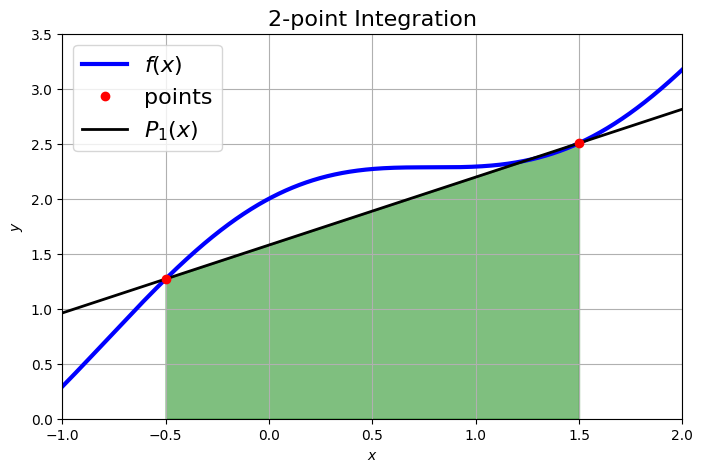

In [6]:
#Function
def f(x):
    return 1+np.cos(x)**2+x

#Choose a region to integrate over and take only a few points in that region
#Quadrature with 2 points (Trapezoidal rule)

X = np.array([-0.5,1.5])

#Interpolation add-on
import scipy.interpolate as interp
# Plot both the function and the area below it in the trapezoid approximation
Integration( f, X, xmin=-1, xmax=2, ymin=0, ymax=3.5 )


### The composite trapezoidal rule

This formula is obtained when we subdivide the overall interval of integration $[a,b]$ into several subsets of two points, such that we can apply the previous Trapezoidal rule to each subset.

Let $f(x)$ be a well-behaved function ($f\in C^2[a,b]$), and define the step size as $h = (b-a)/N$, where $N$ is the number of intervals we consider. The **Composite Trapezoidal rule** is given by:

$$ \int_a^b f(x) dx = \frac{h}{2}\left[ f(a) + 2\sum_{j=1}^{N-1}f(x_j) + f(b) \right] - \frac{b-a}{12}h^2 f^{''}(\mu)$$

for some value $\mu$ in $(a,b)$.

In [5]:
#Composite Integration method
def CompositeIntegration( f, a, b, N, n, xmin, xmax, ymin=0, ymax=1 ):
    #X array
    X = np.linspace( a, b, N )
    
    #Plotting
    fig = plt.figure( figsize = (8,5) )
    for i in range(0,N-n,n):
        Xi = X[i:i+n+1]
        ax = Integration( f, Xi, X[i], X[i+n], fig=fig, leg=False )
    
    #X array
    Xarray = np.linspace( xmin, xmax, 1000 )
    #F array
    Yarray = f( Xarray )
    #Function
    ax.plot( Xarray, Yarray, linewidth = 3, color = "blue", label="$f(x)$", zorder=0 )
    #ax.set_title( "%d-point Quadrature"%(N), fontsize=16 )
    #Format
    plt.xlim( (xmin, xmax) )
    plt.ylim( (ymin, ymax) )
    
    return None


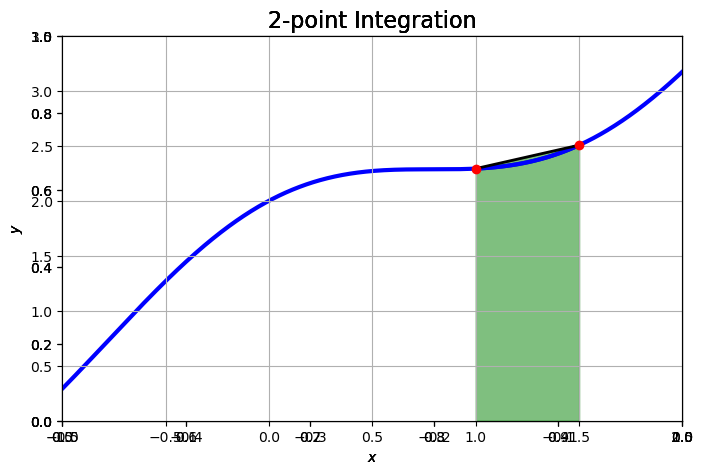

In [7]:
#Integration with 5 intervals (Trapezoid rule)
CompositeIntegration( f, a=-0.5, b=1.5, N=5, n=1, xmin=-1, xmax=2, ymin=0, ymax=3.5)

Using simple integration rules we can obtain the formula for the composite Trapezoidal method.

\begin{align}
\int_a^b f(x)\,dx &= \int_{x_0}^{x_1} f(x) dx + \int_{x_1}^{x_2} f(x) dx + \ldots + \int_{x_{n-1}}^{x_n} f(x) dx,     \nonumber \\ 
                  &\approx h \frac{f(x_0) + f(x_1)}{2} +
		  h \frac{f(x_1) + f(x_2)}{2} + \ldots + \nonumber \\ 
		  &\quad h \frac{f(x_{n-1}) + f(x_n)}{2} 
\end{align}



$$\int_a^b f(x)\,dx \approx  
\frac{h}{2}\left[f(x_0) + 2 f(x_1) + 2 f(x_2) + \ldots + 2 f(x_{n-1}) + f(x_n)\right]              
$$




$$
\int_a^b f(x)\,dx \approx h \left[\frac{1}{2}f(x_0) + \sum_{i=1}^{n-1}f(x_i) + \frac{1}{2}f(x_n) \right] \thinspace .
$$

For example, when $n = 2$


$${\frac  {b-a}{2}}(f_{0}+f_{1})$$

### A Simple Implementation of the trapezoidal rule

In [6]:
def trapezoidal(f, a, b, n):
    h = float(b-a)/n
    result = 0.5*f(a) + 0.5*f(b)
    for i in range(1, n):
        result += f(a + i*h)
    result *= h
    return result



Let's use scipy's quadrature routines as a benchmark

In [7]:
a = -.5
b = 1.5

#Use scipy
from scipy.integrate import quad
integral, error = quad(f, a, b)
print("The integral is:", integral, "+/-", error)

The integral is: 4.245647748216942 +/- 4.713615884518398e-14


Let's compare it to our implementation of the trapezoidal rule

In [8]:
#Select the number of intervals n
n = 2

#Now use the function "trapezoidal" that we created above
integral_trapezoid = trapezoidal(f, a, b, n)

print("The trapezoidal approximation with", (n), "points is:", integral_trapezoid)

The trapezoidal approximation with 2 points is: 4.157728605250994


In [9]:
#Using more points improves the accuracy of the computed integral

#n = 10
#n = 100
n = 1000

#Let's use again the function "trapezoidal" that we created above
integral_trapezoid = trapezoidal(f, a, b, n)

print("The trapezoidal approximation with", (n), "points is:", integral_trapezoid)

The trapezoidal approximation with 1000 points is: 4.245647420686521


### Properties of the Trapezoid Rule

- The trapezoid rule is simple and robust. 

- It is said to be first order exact because, if
not for rounding error, it will exactly compute the integral of any first order polynomial (i.e., a line). 

- In general, if the integrand $f$ is smooth, the trapezoid rule will yield an
approximation error that is $O(h^2)$, that is, the error shrinks quadratically with the width of
the subintervals.

- Doubling the nodes reduces the error by a factor of four.

The routine that follows is the Python translation of the Matlab codes that are included in the textbook.

In [10]:
def qnwtrap(n, a, b):
    """
    Computes multivariate trapezoid rule quadrature nodes and weights.
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    a : scalar or array_like(float)
        A length-d iterable of lower endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    b : scalar or array_like(float)
        A length-d iterable of upper endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwtrap`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    return _make_multidim_func(_qnwtrap1, n, a, b)

###  The Values and Weights of the Integration Nodes

Calling the routines above shows how integration boils down to obtaining values for the nodes and weights

#### Inputs 

1. $n$, the number of nodes 

2. $a$, the left integration limit 

3.  $b$, the right integration limit

In [11]:
# qnwtrap generates integration nodes and weights for trapezoid rule as follows
a = -.5
b = 1.5
n = 5 # must be greater than 1
x,w = qnwtrap(n,a,b)

In [12]:
#nodes and weights
x,w

(array([-0.5,  0. ,  0.5,  1. ,  1.5]), array([0.25, 0.5 , 0.5 , 0.5 , 0.25]))


#### Output
1.  $x$ and $w$, the $n×1$ vectors of quadrature nodes and weights, respectively

#### An Example

To compute the probability that a standard normal random variable is less than 1, execute

In [13]:
f = lambda  x: np.exp(-x**2/2)/np.sqrt(2*np.pi)

n = 21; a = 0; b = 1 
x,w = qnwtrap(n,a,b) 
prob = 0.5 + w@f(x)
print("The trapezoidal approximation with", (n), "points is:", prob)

The trapezoidal approximation with 21 points is: 0.8412943312993039


The computed answer, 0.8413, is correct to four significant digits

In [14]:
#Notice the challenge of working with an infinite support
n = 100; a = -10; b = 1 
x,w = qnwtrap(n,a,b) 
prob = w@f(x)
print("The trapezoidal approximation with", (n), "points is:", prob)

The trapezoidal approximation with 100 points is: 0.841095702458613


### 5.1.2 Simpson's rule

Simpson's rule is based on piece-wise quadratic, rather than piece-wise linear, approximations
to the integrand $f$.



![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Simpsons_method_illustration.svg/440px-Simpsons_method_illustration.svg.png)

Simpson's rule can be derived by approximating the integrand $f(x)$ (in blue) by the quadratic interpolant $P(x)$ (in red).


https://en.wikipedia.org/wiki/Simpson%27s_rule




It is based on piecewise quadratic approximations, obtained by connecting successive triplets of graph points ( $\left[ \, f(x_{2j-1}) ,\, f(x_{2j}) ,\, f(x_{2j+1}) \, \right]$), with quadratic functions.

The area under this quadratic function provides an estimate of the area under $f$ over the
subinterval:

$$\int \limits_{x_{2j-1}}^{x_{2j+1}} f(x)\, d x \approx \frac{h}{3} \left[ \, f(x_{2j-1}) + 4 \, f(x_{2j}) + f(x_{2j+1}) \, \right]$$

where:

- $x_i = a + ih$ are the nodes
- $h$ is the step size equal to $ h=(b − a)/n$, with $n$ an odd number. 
- $w_i$ are the weights.


Summing up the areas under the quadratic approximants across subintervals yields Simpson's
rule:

$$\int_a^b f(x)dx \approx \sum_{i=0}^{n} w_if(x_i)\thinspace .$$

- where $w_0 = w_n = h/3$ 
- $w_i = 4h/3$ if $i$ is even 
- $w_i = 2h/3$ if $i$ is odd.

<Axes: title={'center': '3-point Integration'}, xlabel='$x$', ylabel='$y$'>

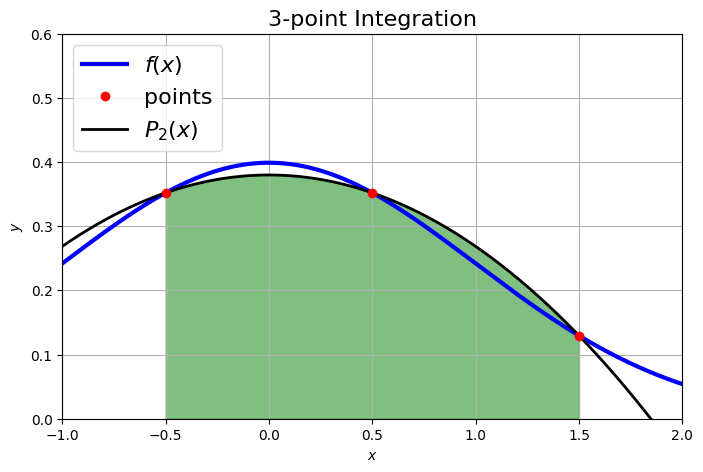

In [15]:
#Integration with 3 points (Simpson's rule)
X = np.array([-0.5,0.5,1.5])
# change the y-lim to 0-1
Integration( f, X, xmin=-1, xmax=2, ymin=0, ymax=0.6 )

More formally, let $x_i = a + ih$ for $i = 1, 2, ... ,n$, where
$ h=(b − a) /n$ and $n$ is odd. The nodes $x_i$ divide the interval $[a, b]$ into an even number
$n$ of subintervals of equal length $h$.

### The Composite Simpson's rule

When we divide the integration interval in sets of three points, we can apply Simpson's rule to each one, obtaining:

$$ \int_a^bf(x)dx = \frac{h}{3}\left[ f(a) +2 \sum_{j=1}^{(n/2)-1}f(x_{2j})+4\sum_{j=1}^{n/2}f(x_{2j-1})+f(b) \right] - \frac{b-a}{180}h^4f^{(4)}(\mu)$$

for some value $\mu$ in $(a,b)$.

Simpson's rule is as simple as the trapezoid rule, and thus not much harder to program.
Even though Simpson's rule is based on *locally quadratic approximation* of the integrand,
it is *third order exact*. That is, it exactly computes the integral of any cubic polynomial.
In general, if the integrand is smooth, Simpson's rule yields an approximation error that is
$O(h^4)$, and thus falls at twice the geometric rate of the error associated with the trapezoid
rule.


*Simpson's rule is preferred to the trapezoid rule* when the integrand $f$ is smooth because
it retains the algorithmic simplicity of the trapezoid rule while offering **twice the degree of
accuracy**. However, the trapezoid rule will often be more accurate than Simpson's rule
if the integrand exhibits **discontinuities in its first order derivative**, which can occur in economic
applications exhibiting corner solutions. Newton-Cotes rules based on fourth and higher
order piecewise polynomial approximations exist, but are more difficult to work with and
thus are rarely used.

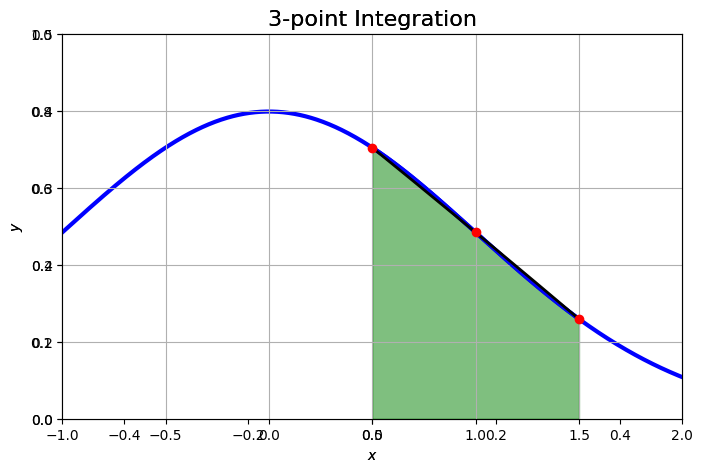

In [16]:
#Integration with 5 intervals (Simpson's rule)
CompositeIntegration( f, a=-0.5, b=1.5, N=5, n=2, xmin=-1, xmax=2, ymin=0, ymax=0.5 )

### Univariate and multivariate Simpson's rule

By using tensor product methods, univariate Newton-Cotes quadrature schemes can be generalized to higher dimensional integration. This principle can be applied to an arbitrary dimension using repeated tensor product operations.

In [17]:
def qnwsimp(n, a, b):
    """
    Computes multivariate Simpson quadrature nodes and weights.
    Parameters
    ----------
    n : int or array_like(float)
        A length-d iterable of the number of nodes in each dimension
    a : scalar or array_like(float)
        A length-d iterable of lower endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    b : scalar or array_like(float)
        A length-d iterable of upper endpoints. If a scalar is given,
        that constant is repeated d times, where d is the number of
        dimensions
    Returns
    -------
    nodes : np.ndarray(dtype=float)
        Quadrature nodes
    weights : np.ndarray(dtype=float)
        Weights for quadrature nodes
    Notes
    -----
    Based of original function ``qnwsimp`` in CompEcon toolbox by
    Miranda and Fackler
    References
    ----------
    Miranda, Mario J, and Paul L Fackler. Applied Computational
    Economics and Finance, MIT Press, 2002.
    """
    return _make_multidim_func(_qnwsimp1, n, a, b)

### Properties of the Simpson rule

1. If $f(x)$ is smooth, Simpson's rule approximation error is proportional to $h^4$

2. Doubling the nodes reduces the error by a factor of sixteen

3. Simpson's rule is preferred to the trapezoid rule because it is almost as simple, but more accurate

4. Newton-Cotes rules based on piecewise polynomials of third and higher degree can be defined, but are not practical

In [18]:
# qnwsimp generates integration nodes and weights for Simpson's rule as follows
a = -.5
b = 1.5
n = 3 # n must be an odd integer
x,w = qnwsimp(n,a,b)

In [19]:
#nodes and weights
x,w

(array([-0.5,  0.5,  1.5]), array([0.33333333, 1.33333333, 0.33333333]))

#### An Example

To compute the probability that a standard normal random variable is less than 1, execute

In [20]:
#Let's define the pdf of the standard normal 
f = lambda  x: np.exp(-x**2/2)/np.sqrt(2*np.pi)

n = 11; a = 0; b = 1 
x,w = qnwsimp(n,a,b) 
prob = 0.5 + w@f(x)
print("The Simpson's approximation with", (n), "points is:", prob)

The Simpson's approximation with 11 points is: 0.8413450158884701


qnwsimp uses fewer nodes than qntrap to obtain a similar degree of accuracy.

In [21]:
negexp = lambda  x: np.exp(-x)

areatrue = np.exp(1.0)-np.exp(-1.0)

n = 5
#n = 11
#n = 21
#n = 31
a = -1
b = 1 

x,w = qnwtrap(n,a,b) 
areatrap = w@negexp(x)
print("The trapezoidal approximation with", (n), "points is:", areatrap)
errortrap=areatrap/areatrue
relerrortrap=(areatrap/areatrue)-1.0
relerrortrap=np.abs(relerrortrap)
print("The Relative Error of the trapezoidal approximation with", (n), "points is:", relerrortrap)
print("The Log 10 Relative Error of the trapezoidal approximation with", (n), "points is:", np.log10(relerrortrap))

x,w = qnwsimp(n,a,b) 
areasimp = w@negexp(x)
print("The Simpson's approximation with", (n), "points is:", areasimp)
errorsimp=areasimp/areatrue
relerrorsimp=(areasimp/areatrue)-1.0
relerrorsimp=np.abs(relerrorsimp)
print("The Relative Error of Simpson's approximation with", (n), "points is:", relerrorsimp)
print("The Log 10 Relative Error of the trapezoidal approximation with", (n), "points is:", np.log10(relerrorsimp))

The trapezoidal approximation with 5 points is: 2.3991662826140026
The Relative Error of the trapezoidal approximation with 5 points is: 0.020747041268399213
The Log 10 Relative Error of the trapezoidal approximation with 5 points is: -1.683043829189349
The Simpson's approximation with 5 points is: 2.3511948318802554
The Relative Error of Simpson's approximation with 5 points is: 0.00033715273475665164
The Log 10 Relative Error of the trapezoidal approximation with 5 points is: -3.4721733132677617


In [22]:
negexp = lambda  x: np.sqrt(np.abs(x))

areatrue = 4.0/3.0

n = 5
#n = 11
#n = 21
#n = 31
a = -1
b = 1 

x,w = qnwtrap(n,a,b) 
areatrap = w@negexp(x)
print("The trapezoidal approximation with", (n), "points is:", areatrap)
errortrap=areatrap/areatrue
relerrortrap=(areatrap/areatrue)-1.0
relerrortrap=np.abs(relerrortrap)
print("The Relative Error of the trapezoidal approximation with", (n), "points is:", relerrortrap)
print("The Log 10 Relative Error of the trapezoidal approximation with", (n), "points is:", np.log10(relerrortrap))

x,w = qnwsimp(n,a,b) 
areasimp = w@negexp(x)
print("The Simpson's approximation with", (n), "points is:", areasimp)
errorsimp=areasimp/areatrue
relerrorsimp=(areasimp/areatrue)-1.0
relerrorsimp=np.abs(relerrorsimp)
print("The Relative Error of Simpson's approximation with", (n), "points is:", relerrorsimp)
print("The Log 10 Relative Error of the trapezoidal approximation with", (n), "points is:", np.log10(relerrorsimp))

The trapezoidal approximation with 5 points is: 1.2071067811865475
The Relative Error of the trapezoidal approximation with 5 points is: 0.0946699141100894
The Log 10 Relative Error of the trapezoidal approximation with 5 points is: -1.0237880168990077
The Simpson's approximation with 5 points is: 1.2761423749153968
The Relative Error of Simpson's approximation with 5 points is: 0.042893218813452316
The Log 10 Relative Error of the trapezoidal approximation with 5 points is: -1.3676113620036903
